In [1]:
#load libraries
import pandas as pd
import os as os
import numpy as np
import re
import ipywidgets as widgets
from ipywidgets import interactive
import seaborn as sns
import plotly
import plotly.plotly as py
plotly.tools.set_credentials_file(username='jeremielamboley', api_key='Vl2N6wO66g1b8UXimcav')

# display option
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

## scraped database from https://www.henleypassportindex.com

In [2]:
# scrapping script here: https://github.com/jeremielamboley/world-passport-power-rank-enriched/blob/master/henley_passport_index_data_collection.ipynb
df_visa_free = pd.read_csv('https://raw.githubusercontent.com/jeremielamboley/henley/master/henley_visa_free_11_01_2019.csv', encoding = "ISO-8859-1")

In [3]:
df_visa_free.rename(columns={'passport': 'passportfrom_alpha_2code'}, inplace=True)
df_visa_free.rename(columns={'to': 'countryto_alpha_2code'}, inplace=True)

In [4]:
df_visa_free.shape

(45173, 3)

In [5]:
df_visa_free['passportfrom_alpha_2code'].nunique()

198

In [6]:
df_visa_free['countryto_alpha_2code'].nunique()

226

In [7]:
# Let's consider the passport holders countries as a country which gives visa-free access
df_visa_free.loc[df_visa_free['passportfrom_alpha_2code'] == df_visa_free['countryto_alpha_2code'], 'visafree'] = 1

In [8]:
# visafree matrix preview
df_visa_free.sample(5)

,passportfrom_alpha_2code,countryto_alpha_2code,visafree
3094,ZW,FR,0
7296,ZM,TT,1
10389,QA,AF,0
22124,PG,TV,1
41558,BO,MX,0


In [9]:
# Nationals have visa free access to their own countries
df_visa_free[df_visa_free.passportfrom_alpha_2code == df_visa_free.countryto_alpha_2code].head()

,passportfrom_alpha_2code,countryto_alpha_2code,visafree
9,AM,AM,1
234,AG,AG,1
267,AO,AO,1
316,AR,AR,1
351,DZ,DZ,1


## List of world countries with ISO codes
### Source Wikipedia https://en.wikipedia.org/wiki/List_of_ISO_3166_country_codes
### Project by Radcliff https://gist.github.com/radcliff/f09c0f88344a7fcef373

In [10]:
df_iso = pd.read_csv('https://gist.githubusercontent.com/radcliff/f09c0f88344a7fcef373/raw/2753c482ad091c54b1822288ad2e4811c021d8ec/wikipedia-iso-country-codes.csv', encoding = "utf8")

In [11]:
df_iso.rename(columns={'English short name lower case': 'Country name'}, inplace=True)
df_iso.rename(columns={'Alpha-2 code': 'country_alpha_2code'}, inplace=True)
df_iso.rename(columns={'Alpha-3 code': 'country_alpha_3code'}, inplace=True)
df_iso.rename(columns={'Numeric code': 'country_numeric_code'}, inplace=True)
df_iso = df_iso.drop(['ISO 3166-2'], axis=1)

In [12]:
df_iso.shape

(246, 4)

In [13]:
df_iso.sample(5)

,Country name,country_alpha_2code,country_alpha_3code,country_numeric_code
239,"Virgin Islands, British",VG,VGB,92
220,Tokelau,TK,TKL,772
106,Israel,IL,ISR,376
52,Costa Rica,CR,CRI,188
121,Lebanon,LB,LBN,422


## Add the Regions, Standard country or area codes for statistical use (M49)
## https://unstats.un.org/unsd/methodology/m49/overview/

In [14]:
df_regions = pd.read_csv('https://raw.githubusercontent.com/jeremielamboley/world-passport-power-rank-enriched/master/UNSD-M49-25-01-2019.csv', 
                        encoding = "ISO-8859-1", 
                        delimiter = ',',
                        header=0)

In [15]:
df_regions.sample(5)

,Global Code,Global Name,Region Code,Region Name,Sub-region Code,Sub-region Name,Intermediate Region Code,Intermediate Region Name,Country or Area,M49 Code,ISO-alpha3 Code,Least Developed Countries (LDC),Land Locked Developing Countries (LLDC),Small Island Developing States (SIDS),Developed / Developing Countries
115,1,World,19.0,Americas,21.0,Northern America,NaN,NaN,Saint Pierre and Miquelon,666,SPM,NaN,NaN,NaN,Developed
118,1,World,142.0,Asia,143.0,Central Asia,NaN,NaN,Kazakhstan,398,KAZ,NaN,x,NaN,Developing
93,1,World,19.0,Americas,419.0,Latin America and the Caribbean,13.0,Central America,Mexico,484,MEX,NaN,NaN,NaN,Developing
237,1,World,9.0,Oceania,57.0,Micronesia,NaN,NaN,Palau,585,PLW,NaN,NaN,x,Developing
143,1,World,142.0,Asia,34.0,Southern Asia,NaN,NaN,Bhutan,64,BTN,x,x,NaN,Developing


In [16]:
#df_regions['Developed / Developing Countries'] = df_regions.loc[df_regions['Least Developed Countries (LDC)'] == 'x','Developed / Developing Countries'] = 'Least Developed'
df_regions['Developed / Developing Countries'] = np.where(df_regions['Least Developed Countries (LDC)'] == 'x', 'Least Developed', df_regions['Developed / Developing Countries'])

In [17]:
df_regions.sample(5)

,Global Code,Global Name,Region Code,Region Name,Sub-region Code,Sub-region Name,Intermediate Region Code,Intermediate Region Name,Country or Area,M49 Code,ISO-alpha3 Code,Least Developed Countries (LDC),Land Locked Developing Countries (LLDC),Small Island Developing States (SIDS),Developed / Developing Countries
149,1,World,142.0,Asia,34.0,Southern Asia,NaN,NaN,Sri Lanka,144,LKA,NaN,NaN,NaN,Developing
60,1,World,19.0,Americas,419.0,Latin America and the Caribbean,29.0,Caribbean,Anguilla,660,AIA,NaN,NaN,x,Developing
137,1,World,142.0,Asia,35.0,South-eastern Asia,NaN,NaN,Singapore,702,SGP,NaN,NaN,x,Developing
230,1,World,9.0,Oceania,54.0,Melanesia,NaN,NaN,Vanuatu,548,VUT,x,NaN,x,Least Developed
196,1,World,150.0,Europe,39.0,Southern Europe,NaN,NaN,Andorra,20,AND,NaN,NaN,NaN,Developed


In [18]:
df_regions = df_regions[['ISO-alpha3 Code','Region Name','Sub-region Name','Developed / Developing Countries']]
df_regions = df_regions.rename(columns={'ISO-alpha3 Code':'country_alpha_3code'})
df_regions

,country_alpha_3code,Region Name,Sub-region Name,Developed / Developing Countries
0,DZA,Africa,Northern Africa,Developing
1,EGY,Africa,Northern Africa,Developing
2,LBY,Africa,Northern Africa,Developing
3,MAR,Africa,Northern Africa,Developing
4,SDN,Africa,Northern Africa,Least Developed
5,TUN,Africa,Northern Africa,Developing
6,ESH,Africa,Northern Africa,Developing
7,IOT,Africa,Sub-Saharan Africa,Developing
8,BDI,Africa,Sub-Saharan Africa,Least Developed
9,COM,Africa,Sub-Saharan Africa,Least Developed


## GDP per countries in USD, 2016, from the United Nations Statistics Division
### Source: http://data.un.org/

In [19]:
df_GDP_UN = pd.read_csv('http://data.un.org/_Docs/SYB/CSV/SYB61_T13_GDP%20and%20GDP%20Per%20Capita.csv', 
                        encoding = "ISO-8859-1", 
                        delimiter = ',',
                        header=1)

In [20]:
# filter the data to GDP in 2016
df_GDP_UN = df_GDP_UN[df_GDP_UN['Series'] == 'GDP in current prices (millions of US dollars)']
df_GDP_UN = df_GDP_UN[df_GDP_UN.Year == 2016]

In [21]:
# Organize the data
df_GDP_UN['Value'] = df_GDP_UN['Value'].str.replace(',', '')
df_GDP_UN['Value'] = df_GDP_UN['Value'].astype(int)
# Renaming columns
df_GDP_UN.rename(columns={'Region/Country/Area': 'country_numeric_code'}, inplace=True)
df_GDP_UN.rename(columns={'Value': 'UN_GDP_currentPrices2016'}, inplace=True)
# Convert GDP from millions to billions
df_GDP_UN['UN_GDP_currentPrices2016_billions'] = df_GDP_UN['UN_GDP_currentPrices2016'] / 1000

In [22]:
df_GDP_UN.shape

(242, 8)

In [23]:
df_GDP_UN.sample(5)

,country_numeric_code,Unnamed: 1,Year,Series,UN_GDP_currentPrices2016,Footnotes,Source,UN_GDP_currentPrices2016_billions
1638,100,Bulgaria,2016,GDP in current prices (millions of US dollars),53240,NaN,"United Nations Statistics Division, New York, ...",53.240
5700,724,Spain,2016,GDP in current prices (millions of US dollars),1237255,NaN,"United Nations Statistics Division, New York, ...",1237.255
6275,804,Ukraine,2016,GDP in current prices (millions of US dollars),93270,Excludes the temporarily occupied territory of...,"United Nations Statistics Division, New York, ...",93.270
2489,218,Ecuador,2016,GDP in current prices (millions of US dollars),98010,NaN,"United Nations Statistics Division, New York, ...",98.010
2841,270,Gambia,2016,GDP in current prices (millions of US dollars),986,NaN,"United Nations Statistics Division, New York, ...",0.986


In [24]:
df_GDP_UN = df_GDP_UN[['country_numeric_code','UN_GDP_currentPrices2016_billions']]

### World total GDP for 2016 to get a % of coverage per passport

In [25]:
# country code = 1 for the world aggregate
df_GDP_UN['UN_World_GDP_percent'] = df_GDP_UN['UN_GDP_currentPrices2016_billions'] / df_GDP_UN[df_GDP_UN['country_numeric_code'] == 1].iloc[0,1]

In [26]:
df_GDP_UN.sample(5)

,country_numeric_code,UN_GDP_currentPrices2016_billions,UN_World_GDP_percent
1862,140,1.810,0.000024
562,150,19026.676,0.251513
3369,372,304.819,0.004029
2142,188,57.436,0.000759
202,11,568.706,0.007518


# Population and surface, 2015, from the United Nations Statistics Division

### Source: http://data.un.org/

In [27]:
df_population_surface_UN = pd.read_csv('http://data.un.org/_Docs/SYB/CSV/SYB61_T02_Population,%20Surface%20Area%20and%20Density.csv', 
                        encoding = "ISO-8859-1", 
                        delimiter = ',',
                        header=1)

In [28]:
# filter the data to GDP in 2015
df_population_surface_UN = df_population_surface_UN[(df_population_surface_UN['Series'] == 'Population mid-year estimates (millions)') | (df_population_surface_UN['Series'] == 'Surface area (thousand km2)')]
df_population_surface_UN = df_population_surface_UN[df_population_surface_UN['Year'] == 2015]

In [29]:
# Organize the data
df_population_surface_UN['Value'] = df_population_surface_UN['Value'].str.replace(',', '')
df_population_surface_UN['Value'] = df_population_surface_UN['Value'].astype(float)

In [30]:
df_population_surface_UN = df_population_surface_UN[['Region/Country/Area','Series','Value']]
df_population_surface_UN.rename(columns={'Region/Country/Area': 'country_numeric_code'}, inplace=True)

In [31]:
# pivot and un-pivot
df_population_surface_UN = df_population_surface_UN.pivot(index='country_numeric_code', columns='Series', values='Value')
df_population_surface_UN = pd.DataFrame(df_population_surface_UN.to_records())

In [32]:
# get the world total for population and surface
df_population_UN_world = df_population_surface_UN[(df_population_surface_UN.country_numeric_code == 1)].iloc[0,1]
df_surface_UN_world = df_population_surface_UN[(df_population_surface_UN.country_numeric_code == 1)].iloc[0,2]

In [33]:
# World Population mid-year estimates 7383 millions, 2015
# Source: United Nations Statistics Division, New York, World Population Prospects: The 2017 Revision, last accessed June 2017.
df_population_surface_UN['UN_population_Value_2015_percent'] = (df_population_surface_UN['Population mid-year estimates (millions)'] / df_population_UN_world)

In [34]:
df_population_surface_UN['Surface_area_convered_percent'] = (df_population_surface_UN['Surface area (thousand km2)'] / df_surface_UN_world)

In [35]:
df_population_surface_UN.sample(5)

,country_numeric_code,Population mid-year estimates (millions),Surface area (thousand km2),UN_population_Value_2015_percent,Surface_area_convered_percent
70,170,48.23,1142.0,0.006533,0.008387
174,548,0.26,12.0,0.000035,0.000088
41,68,10.72,1099.0,0.001452,0.008071
232,772,0.00,0.0,0.000000,0.000000
235,784,9.15,84.0,0.001239,0.000617


# Unesco World Heritage list 

### https://whc.unesco.org/en/syndication

In [36]:
# Fetch the data from the Unesco website
unesco = pd.read_excel('https://whc.unesco.org/en/list/xls/whc-sites-2018.xls', encoding="Windows-1252",header=0)
unesco = unesco.reindex(['name_en', 'iso_code'], axis="columns")

In [37]:
# check the shape
unesco.shape

(1092, 2)

In [38]:
# Some values are comma separated and need to be reformated
unesco.tail(5)

,name_en,iso_code
1087,Prehistoric Rock Art Sites in the Côa Valley a...,"pt,es"
1088,Uvs Nuur Basin,"ru,mn"
1089,Landscapes of Dauria,"ru,mn"
1090,Heritage of Mercury. Almadén and Idrija,"si,es"
1091,Mosi-oa-Tunya / Victoria Falls,"zm,zw"


In [39]:
# Split the values
unesco = pd.concat([unesco['name_en'], unesco['iso_code'].str.split(',', expand=True)], axis=1)

unesco2 = []
for i in range(0,11):
    temp = unesco.loc[:,['name_en',i]]
    temp.columns = ['name_en','countryto_alpha_2code']
    unesco2.append(temp)
unesco2 = pd.concat(unesco2, ignore_index=True)

# Remove empty values
unesco2 = unesco2.replace(to_replace='None', value=np.nan).dropna().reset_index(drop=True)
# preview
unesco2.sample(5)

,name_en,countryto_alpha_2code
1130,Prehistoric Pile Dwellings around the Alps,de
989,Historic Town of St George and Related Fortifi...,gb
1154,Struve Geodetic Arc,no
469,The Persian Qanat,ir
1076,Muskauer Park / Park Mużakowski,de


In [40]:
# create a pivot table
unesco_pivot = pd.pivot_table(unesco2,index=['countryto_alpha_2code'], aggfunc='count')
unesco_pivot = pd.DataFrame(unesco_pivot.to_records())
unesco_pivot = unesco_pivot.rename(columns = {'name_en' :'unesco_total_sites'})
unesco_pivot = unesco_pivot.sort_values('unesco_total_sites',ascending=False)

In [41]:
# Count the total of world unesco sites
unesco_total_sites = unesco_pivot['unesco_total_sites'].sum()
# create the % of sites located in each country
unesco_pivot['unesco_total_sites_percent'] = (unesco_pivot['unesco_total_sites'] / unesco_total_sites)

In [42]:
# change to uppercase
unesco_pivot['countryto_alpha_2code'] = unesco_pivot['countryto_alpha_2code'].str.upper()

In [43]:
unesco_pivot.sample(5)

,countryto_alpha_2code,unesco_total_sites,unesco_total_sites_percent
51,FJ,1,0.000858
116,NP,4,0.003431
159,VA,2,0.001715
155,UG,3,0.002573
132,RU,28,0.024014


## Intersect df_iso and df_regions

In [44]:
df_iso = pd.merge(df_iso, df_regions, how='left', on='country_alpha_3code')
df_iso.sample(5)

,Country name,country_alpha_2code,country_alpha_3code,country_numeric_code,Region Name,Sub-region Name,Developed / Developing Countries
109,Japan,JP,JPN,392,Asia,Eastern Asia,Developed
191,San Marino,SM,SMR,674,Europe,Southern Europe,Developed
185,Saint Kitts and Nevis,KN,KNA,659,Americas,Latin America and the Caribbean,Developing
207,Sudan,SD,SDN,736,Africa,Northern Africa,Least Developed
117,Kuwait,KW,KWT,414,Asia,Western Asia,Developing


## Intersect df_visa_free and df_iso on 'country to'

In [45]:
# copy df_visa_free, rename the columns from centadata and hauntedhouse
df_visa_free2 = df_visa_free.copy()

In [46]:
df_visa_free2.rename(columns={'countryto_alpha_2code': 'country_alpha_2code'}, inplace=True)

In [47]:
# Intersect on 'countryto_alpha_2code'
df = pd.merge(df_visa_free2, df_iso, on=['country_alpha_2code'], how='left')

In [48]:
df.rename(columns={'country_alpha_2code': 'countryto_alpha_2code'}, inplace=True)
df.rename(columns={'Country name': 'countryto_Country_name'}, inplace=True)
df.rename(columns={'country_alpha_3code': 'countryto_country_alpha_3code'}, inplace=True)
df.rename(columns={'country_numeric_code': 'countryto_country_numeric_code'}, inplace=True)

In [49]:
df['passportfrom_alpha_2code'].nunique()

198

In [50]:
df['countryto_alpha_2code'].nunique()

226

In [51]:
df.sample(10)

,passportfrom_alpha_2code,countryto_alpha_2code,visafree,countryto_Country_name,countryto_country_alpha_3code,countryto_country_numeric_code,Region Name,Sub-region Name,Developed / Developing Countries
41357,TD,NR,0,Nauru,NRU,520.0,Oceania,Micronesia,Developing
36444,HR,DM,1,Dominica,DMA,212.0,Americas,Latin America and the Caribbean,Developing
23730,XK,CR,0,Costa Rica,CRI,188.0,Americas,Latin America and the Caribbean,Developing
17082,SS,TJ,0,Tajikistan,TJK,762.0,Asia,Central Asia,Developing
42195,BH,LI,0,Liechtenstein,LIE,438.0,Europe,Western Europe,Developed
44934,BD,TJ,0,Tajikistan,TJK,762.0,Asia,Central Asia,Developing
3980,UZ,BW,0,Botswana,BWA,72.0,Africa,Sub-Saharan Africa,Developing
17233,NE,GR,0,Greece,GRC,300.0,Europe,Southern Europe,Developed
37466,DK,GE,1,Georgia,GEO,268.0,Asia,Western Asia,Developing
28389,MG,NZ,0,New Zealand,NZL,554.0,Oceania,Australia and New Zealand,Developed


## Intersect df_visa_free and df_iso on 'passport'

In [52]:
df_iso.rename(columns={'country_alpha_2code': 'passportfrom_alpha_2code'}, inplace=True)

In [53]:
# Intersect on 'passportfrom_alpha_2code'
df = pd.merge(df, df_iso, on=['passportfrom_alpha_2code'], how='left')

In [54]:
df_iso.rename(columns={'passportfrom_alpha_2code': 'country_alpha_2code'}, inplace=True)

In [55]:
df.rename(columns={'Country name': 'passportfrom_Country_name'}, inplace=True)

In [56]:
df = df.drop(['country_alpha_3code'], axis=1)
df = df.drop(['country_numeric_code'], axis=1)

## Intersect df and df_GDP_UN

In [57]:
df_GDP_UN2 = df_GDP_UN.copy()
df_GDP_UN2.rename(columns={'country_numeric_code': 'countryto_country_numeric_code'}, inplace=True)

In [58]:
df2 = pd.merge(df, df_GDP_UN2, on=['countryto_country_numeric_code'], how='left')

In [59]:
df2.rename(columns={'UN_GDP_currentPrices2016_billions': 'countryto_UN_GDP_currentPrices2016'}, inplace=True)

In [60]:
df2.sample(5)

,passportfrom_alpha_2code,countryto_alpha_2code,visafree,countryto_Country_name,countryto_country_alpha_3code,countryto_country_numeric_code,Region Name_x,Sub-region Name_x,Developed / Developing Countries_x,passportfrom_Country_name,Region Name_y,Sub-region Name_y,Developed / Developing Countries_y,countryto_UN_GDP_currentPrices2016,UN_World_GDP_percent
41135,CG,NaN,0,Namibia,NAM,516.0,Africa,Sub-Saharan Africa,Developing,Congo,Africa,Sub-Saharan Africa,Developing,10.947,0.000145
11894,SO,PF,0,French Polynesia,PYF,258.0,Oceania,Polynesia,Developing,Somalia,Africa,Sub-Saharan Africa,Least Developed,5.418,0.000072
20064,MT,AT,1,Austria,AUT,40.0,Europe,Western Europe,Developed,Malta,Europe,Southern Europe,Developed,390.800,0.005166
40126,CO,KI,0,Kiribati,KIR,296.0,Oceania,Micronesia,Least Developed,Colombia,Americas,Latin America and the Caribbean,Developing,0.174,0.000002
23171,PG,YE,0,Yemen,YEM,887.0,Asia,Western Asia,Least Developed,Papua New Guinea,Oceania,Melanesia,Developing,25.374,0.000335


## Intersect df2 and df_population_UN

In [61]:
df_population_UN2 = df_population_surface_UN.copy()
df_population_UN2.rename(columns={'country_numeric_code': 'countryto_country_numeric_code'}, inplace=True)

In [62]:
df3 = pd.merge(df2, df_population_UN2, on=['countryto_country_numeric_code'], how='left')

In [63]:
#df3.rename(columns={'UN_population_Value_2015_millions': 'countryto_UN_population_Value_2015_millions'}, inplace=True)
df3.rename(columns={'Population mid-year estimates (millions)': 'countryto_UN_population_Value_2015_millions'}, inplace=True)
df3.rename(columns={'Surface area (thousand km2)': 'countryto_Surface area (thousand km2)'}, inplace=True)

In [64]:
df3.sample(5)

,passportfrom_alpha_2code,countryto_alpha_2code,visafree,countryto_Country_name,countryto_country_alpha_3code,countryto_country_numeric_code,Region Name_x,Sub-region Name_x,Developed / Developing Countries_x,passportfrom_Country_name,Region Name_y,Sub-region Name_y,Developed / Developing Countries_y,countryto_UN_GDP_currentPrices2016,UN_World_GDP_percent,countryto_UN_population_Value_2015_millions,countryto_Surface area (thousand km2),UN_population_Value_2015_percent,Surface_area_convered_percent
18002,SA,SN,0,Senegal,SEN,686.0,Africa,Sub-Saharan Africa,Least Developed,Saudi Arabia,Asia,Western Asia,Developing,14.605,0.000193,14.98,197.0,0.002029,0.001447
32100,FR,FO,1,Faroe Islands,FRO,234.0,Europe,Northern Europe,Developed,France,Europe,Western Europe,Developed,NaN,NaN,0.05,1.0,0.000007,0.000007
11163,SA,CO,0,Colombia,COL,170.0,Americas,Latin America and the Caribbean,Developing,Saudi Arabia,Asia,Western Asia,Developing,282.463,0.003734,48.23,1142.0,0.006533,0.008387
112,AM,LB,1,Lebanon,LBN,422.0,Asia,Western Asia,Developing,Armenia,Asia,Western Asia,Developing,50.458,0.000667,5.85,10.0,0.000792,0.000073
32870,IE,TR,0,Turkey,TUR,792.0,Asia,Western Asia,Developing,Ireland,Europe,Northern Europe,Developed,863.712,0.011417,78.27,784.0,0.010601,0.005758


## Intersect df3 and unesco_pivot

In [65]:
unesco_pivot2 = unesco_pivot.copy()

In [66]:
df4 = pd.merge(df3, unesco_pivot2, on=['countryto_alpha_2code'], how='left')

In [67]:
df4.sample(5)

,passportfrom_alpha_2code,countryto_alpha_2code,visafree,countryto_Country_name,countryto_country_alpha_3code,countryto_country_numeric_code,Region Name_x,Sub-region Name_x,Developed / Developing Countries_x,passportfrom_Country_name,Region Name_y,Sub-region Name_y,Developed / Developing Countries_y,countryto_UN_GDP_currentPrices2016,UN_World_GDP_percent,countryto_UN_population_Value_2015_millions,countryto_Surface area (thousand km2),UN_population_Value_2015_percent,Surface_area_convered_percent,unesco_total_sites,unesco_total_sites_percent
29902,LU,RS,1,Serbia,SRB,688.0,Europe,Southern Europe,Developed,Luxembourg,Europe,Western Europe,Developed,38.300,0.000506,8.85,88.0,0.001199,0.000646,5.0,0.004288
2331,BW,GL,0,Greenland,GRL,304.0,Americas,Northern America,Developed,Botswana,Africa,Sub-Saharan Africa,Developing,2.283,0.000030,0.06,2166.0,0.000008,0.015908,NaN,NaN
33173,IE,VA,1,Holy See (Vatican City State),VAT,336.0,Europe,Southern Europe,Developed,Ireland,Europe,Northern Europe,Developed,NaN,NaN,0.00,0.0,0.000000,0.000000,2.0,0.001715
17134,RO,FM,1,"Micronesia, Federated States of",FSM,583.0,Oceania,Micronesia,Developing,Romania,Europe,Eastern Europe,Developed,0.330,0.000004,0.10,1.0,0.000014,0.000007,1.0,0.000858
15126,PT,FJ,1,Fiji,FJI,242.0,Oceania,Melanesia,Developing,Portugal,Europe,Southern Europe,Developed,4.671,0.000062,0.89,18.0,0.000121,0.000132,1.0,0.000858


## Reordering the columns

In [68]:
df4 = df4.reset_index(drop=True)
cols = df4.columns.tolist()
cols

['passportfrom_alpha_2code',
 'countryto_alpha_2code',
 'visafree',
 'countryto_Country_name',
 'countryto_country_alpha_3code',
 'countryto_country_numeric_code',
 'Region Name_x',
 'Sub-region Name_x',
 'Developed / Developing Countries_x',
 'passportfrom_Country_name',
 'Region Name_y',
 'Sub-region Name_y',
 'Developed / Developing Countries_y',
 'countryto_UN_GDP_currentPrices2016',
 'UN_World_GDP_percent',
 'countryto_UN_population_Value_2015_millions',
 'countryto_Surface area (thousand km2)',
 'UN_population_Value_2015_percent',
 'Surface_area_convered_percent',
 'unesco_total_sites',
 'unesco_total_sites_percent']

In [69]:
df4 = df4[['passportfrom_alpha_2code','passportfrom_Country_name','countryto_alpha_2code','countryto_Country_name','countryto_country_alpha_3code', 'countryto_country_numeric_code','countryto_UN_GDP_currentPrices2016','UN_World_GDP_percent', 'countryto_UN_population_Value_2015_millions','UN_population_Value_2015_percent','countryto_Surface area (thousand km2)','Surface_area_convered_percent','unesco_total_sites','unesco_total_sites_percent','visafree']]

In [70]:
df4['passportfrom_alpha_2code'].nunique()

198

In [71]:
df4.head(5)

,passportfrom_alpha_2code,passportfrom_Country_name,countryto_alpha_2code,countryto_Country_name,countryto_country_alpha_3code,countryto_country_numeric_code,countryto_UN_GDP_currentPrices2016,UN_World_GDP_percent,countryto_UN_population_Value_2015_millions,UN_population_Value_2015_percent,countryto_Surface area (thousand km2),Surface_area_convered_percent,unesco_total_sites,unesco_total_sites_percent,visafree
0,AM,Armenia,AF,Afghanistan,AFG,4.0,20.235,0.000267,33.74,0.004570,653.0,0.004796,2.0,0.001715,0
1,AM,Armenia,AL,Albania,ALB,8.0,11.864,0.000157,2.92,0.000396,29.0,0.000213,3.0,0.002573,1
2,AM,Armenia,DZ,Algeria,DZA,12.0,159.049,0.002102,39.87,0.005400,2382.0,0.017494,7.0,0.006003,0
3,AM,Armenia,AS,American Samoa,ASM,16.0,NaN,NaN,0.06,0.000008,0.0,0.000000,NaN,NaN,0
4,AM,Armenia,AD,Andorra,AND,20.0,2.858,0.000038,0.08,0.000011,0.0,0.000000,1.0,0.000858,0


## Pandas pivot_table 'passport FROM'

In [72]:
df_pivot = pd.pivot_table(df4[df4.visafree == 1],index='passportfrom_Country_name',values=['countryto_UN_GDP_currentPrices2016','UN_World_GDP_percent','countryto_UN_population_Value_2015_millions','UN_population_Value_2015_percent','countryto_Surface area (thousand km2)','Surface_area_convered_percent','unesco_total_sites','unesco_total_sites_percent','visafree'], aggfunc=np.sum, margins=False,dropna=True)
df_pivot.sort_values('visafree', ascending=False)
df_pivot.head(5)

,Surface_area_convered_percent,UN_World_GDP_percent,UN_population_Value_2015_percent,countryto_Surface area (thousand km2),countryto_UN_GDP_currentPrices2016,countryto_UN_population_Value_2015_millions,unesco_total_sites,unesco_total_sites_percent,visafree
passportfrom_Country_name,,,,,,,,,
Afghanistan,0.043228,0.006096,0.053354,5886.0,461.147,393.91,41.0,0.035163,31
Albania,0.235925,0.304711,0.269534,32124.0,23051.078,1989.97,640.0,0.548885,116
Algeria,0.126034,0.040480,0.132256,17161.0,3062.282,976.45,164.0,0.140652,51
Andorra,0.541803,0.758506,0.424193,73773.0,57380.122,3131.82,916.0,0.785592,170
Angola,0.123030,0.044224,0.153492,16752.0,3345.458,1133.23,141.0,0.120926,50


## Turn the pivot table in a Data frame

In [73]:
df_pivot_flattened = pd.DataFrame(df_pivot.to_records())
df_pivot_flattened.sample(5)

,passportfrom_Country_name,Surface_area_convered_percent,UN_World_GDP_percent,UN_population_Value_2015_percent,countryto_Surface area (thousand km2),countryto_UN_GDP_currentPrices2016,countryto_UN_population_Value_2015_millions,unesco_total_sites,unesco_total_sites_percent,visafree
95,Latvia,0.502167,0.740029,0.415782,68376.0,55982.381,3069.72,899.0,0.771012,181
23,Brazil,0.516333,0.424071,0.385629,70305.0,32080.470,2847.10,881.0,0.755575,172
131,Norway,0.578289,0.753441,0.442559,78741.0,56996.925,3267.42,927.0,0.795026,186
91,"Korea, Republic of",0.737394,0.813333,0.660625,100405.0,61527.752,4877.40,1017.0,0.872213,190
18,Benin,0.149462,0.057704,0.197215,20351.0,4365.279,1456.04,173.0,0.148370,62


## Pandas pivot_table 'passport TO'

In [74]:
df_pivot2 = pd.pivot_table(df4[df4.visafree == 1],index='countryto_Country_name',values=['visafree'], aggfunc=np.sum, margins=False,dropna=True)
df_pivot_flattened2 = pd.DataFrame(df_pivot2.to_records())
df_pivot_flattened2.rename(columns = {'countryto_Country_name':'passportfrom_Country_name','visafree':'visafreeTO'}, inplace=True)
df_pivot_flattened2

,passportfrom_Country_name,visafreeTO
0,Afghanistan,1
1,Albania,90
2,Algeria,8
3,American Samoa,41
4,Andorra,94
5,Angola,12
6,Anguilla,84
7,Antigua and Barbuda,106
8,Argentina,88
9,Armenia,134


In [75]:
df_pivot_flattened['Surface_Rank'] = df_pivot_flattened['countryto_Surface area (thousand km2)'].rank(method='min', ascending=False).astype(int)
df_pivot_flattened['GDP_Rank'] = df_pivot_flattened['countryto_UN_GDP_currentPrices2016'].rank(method='min', ascending=False).astype(int)
df_pivot_flattened['Population_Rank'] = df_pivot_flattened['countryto_UN_population_Value_2015_millions'].rank(method='min', ascending=False).astype(int)
df_pivot_flattened['visafree_countries_Rank'] = df_pivot_flattened['visafree'].rank(method='min', ascending=False).astype(int)
df_pivot_flattened['unesco_total_sites_Rank'] = df_pivot_flattened['unesco_total_sites'].rank(method='min', ascending=False).astype(int)

## Calculate the overall ranking

In [76]:
df_pivot_flattened['Overall_ranking_calculation'] = df_pivot_flattened[['visafree_countries_Rank','GDP_Rank','Surface_Rank','Population_Rank','unesco_total_sites_Rank']].sum(axis=1)

In [77]:
df_pivot_flattened['New_Overall_ranking'] = df_pivot_flattened['Overall_ranking_calculation'].rank(method='min', ascending=True).astype(int)

## Rank by sub-regions

In [214]:
df_pivot_flattened['New_Overall_ranking_bySubRegion'] = df_pivot_flattened.groupby('Sub-region Name')['Overall_ranking_calculation'].rank(method='min', ascending=True).astype(int)

In [215]:
df_pivot_flattened

,passportfrom_Country_name,New_Overall_ranking,gain-loss,visafree,visafree_countries_Rank,countryto_UN_GDP_currentPrices2016,GDP_Rank,UN_World_GDP_percent,countryto_UN_population_Value_2015_millions,Population_Rank,UN_population_Value_2015_percent,countryto_Surface area (thousand km2),Surface_Rank,Surface_area_convered_percent,unesco_total_sites,unesco_total_sites_percent,unesco_total_sites_Rank,Overall_ranking_calculation,country_alpha_2code,country_alpha_3code,country_numeric_code,Region Name,Sub-region Name,Developed / Developing Countries,visafreeTO,visaFreeRatio,New_Overall_ranking_bySubRegion
0,Japan,1,0,191,1,69726.300,1,0.921710,5923.63,1,0.802333,86657.0,4,0.636426,1024.0,0.878216,1,8,JP,JPN,392,Asia,Eastern Asia,Developed,68,0.356021,1
1,Singapore,2,0,190,2,69078.830,2,0.913151,4752.05,3,0.643647,90972.0,2,0.668116,1009.0,0.865352,3,12,SG,SGP,702,Asia,South-eastern Asia,Developing,164,0.863158,1
2,"Korea, Republic of",3,-1,190,2,61527.752,6,0.813333,4877.40,2,0.660625,100405.0,1,0.737394,1017.0,0.872213,2,13,KR,KOR,410,Asia,Eastern Asia,Developing,111,0.584211,2
3,France,4,0,189,4,57942.279,7,0.765937,3378.60,16,0.457618,80242.0,9,0.589313,951.0,0.815609,5,41,FR,FRA,250,Europe,Western Europe,Developed,94,0.497354,1
4,Germany,5,-1,189,4,57885.660,8,0.765189,3350.60,17,0.453826,81357.0,8,0.597502,951.0,0.815609,5,42,DE,DEU,276,Europe,Western Europe,Developed,94,0.497354,2
5,Denmark,6,0,188,6,57874.500,9,0.765041,3347.62,18,0.453422,79793.0,10,0.586015,946.0,0.811321,7,50,DK,DNK,208,Europe,Northern Europe,Developed,94,0.500000,1
6,Finland,6,0,188,6,57874.500,9,0.765041,3347.62,18,0.453422,79793.0,10,0.586015,946.0,0.811321,7,50,FI,FIN,246,Europe,Northern Europe,Developed,94,0.500000,1
7,Sweden,6,0,188,6,57874.500,9,0.765041,3347.62,18,0.453422,79793.0,10,0.586015,946.0,0.811321,7,50,SE,SWE,752,Europe,Northern Europe,Developed,94,0.500000,1
8,Italy,6,0,188,6,57874.500,9,0.765041,3347.62,18,0.453422,79793.0,10,0.586015,946.0,0.811321,7,50,IT,ITA,380,Europe,Southern Europe,Developed,94,0.500000,1
9,San Marino,10,36,169,46,68521.709,3,0.905786,4481.94,4,0.607061,82795.0,7,0.608062,959.0,0.822470,4,64,SM,SMR,674,Europe,Southern Europe,Developed,94,0.556213,2


## Create a new column Gain/loss in ranking

In [78]:
df_pivot_flattened['gain-loss'] = df_pivot_flattened['visafree_countries_Rank'] - df_pivot_flattened['New_Overall_ranking']

In [79]:
df_pivot_flattened.sample(5)

,passportfrom_Country_name,Surface_area_convered_percent,UN_World_GDP_percent,UN_population_Value_2015_percent,countryto_Surface area (thousand km2),countryto_UN_GDP_currentPrices2016,countryto_UN_population_Value_2015_millions,unesco_total_sites,unesco_total_sites_percent,visafree,Surface_Rank,GDP_Rank,Population_Rank,visafree_countries_Rank,unesco_total_sites_Rank,Overall_ranking_calculation,New_Overall_ranking,gain-loss
41,Croatia,0.417003,0.475386,0.349349,56780.0,35962.427,2579.25,848.0,0.727273,169,69,59,72,46,52,298,58,-12
46,Denmark,0.586015,0.765041,0.453422,79793.0,57874.500,3347.62,946.0,0.811321,188,10,9,18,6,7,50,6,0
165,Sri Lanka,0.061434,0.022730,0.079637,8365.0,1719.475,587.96,79.0,0.067753,44,191,186,191,180,191,939,188,-8
158,Singapore,0.668116,0.913151,0.643647,90972.0,69078.830,4752.05,1009.0,0.865352,190,2,2,3,2,3,12,2,0
139,Peru,0.449553,0.373666,0.362350,61212.0,28267.442,2675.23,786.0,0.674099,135,55,75,67,74,63,334,64,10


## Reorder the columns

In [80]:
df_pivot_flattened = df_pivot_flattened[['passportfrom_Country_name',
                                         'New_Overall_ranking',
                                         'gain-loss',
                                         'visafree',
                                         'visafree_countries_Rank',
                                         'countryto_UN_GDP_currentPrices2016',
                                         'GDP_Rank',
                                         'UN_World_GDP_percent',
                                         'countryto_UN_population_Value_2015_millions',
                                         'Population_Rank',
                                         'UN_population_Value_2015_percent',
                                         'countryto_Surface area (thousand km2)',
                                         'Surface_Rank',
                                         'Surface_area_convered_percent',
                                         'unesco_total_sites',
                                         'unesco_total_sites_percent',
                                         'unesco_total_sites_Rank',
                                         'Overall_ranking_calculation']]

## New Ranking 

In [81]:
df_iso.rename(columns={'Country name': 'passportfrom_Country_name'}, inplace=True)
df_pivot_flattened = pd.merge(df_pivot_flattened, df_iso, how='left', on='passportfrom_Country_name')

In [82]:
df_pivot_flattened = pd.merge(df_pivot_flattened, df_pivot_flattened2, how='left', on='passportfrom_Country_name')

In [293]:
df_pivot_flattened['visaFreeRatio'] = round((df_pivot_flattened['visafree'] / df_pivot_flattened['visafreeTO']).astype(float),1)

In [294]:
# Re-order and format the values
df_pivot_flattened.sort_values('New_Overall_ranking',ascending=True, inplace=True)
df_pivot_flattened = df_pivot_flattened.reset_index(drop=True)
df_pivot_flattened.style.format({
    'UN_World_GDP_percent': '{:.2%}'.format,
    'UN_population_Value_2015_percent': '{:.2%}'.format,
    'Surface_area_convered_percent': '{:.2%}'.format,
    'unesco_total_sites_percent': '{:.2%}'.format
    })

,passportfrom_Country_name,New_Overall_ranking,gain-loss,visafree,visafree_countries_Rank,countryto_UN_GDP_currentPrices2016,GDP_Rank,UN_World_GDP_percent,countryto_UN_population_Value_2015_millions,Population_Rank,UN_population_Value_2015_percent,countryto_Surface area (thousand km2),Surface_Rank,Surface_area_convered_percent,unesco_total_sites,unesco_total_sites_percent,unesco_total_sites_Rank,Overall_ranking_calculation,country_alpha_2code,country_alpha_3code,country_numeric_code,Region Name,Sub-region Name,Developed / Developing Countries,visafreeTO,visaFreeRatio,New_Overall_ranking_bySubRegion
0,Japan,1,0,191,1,69726.3,1,92.17%,5923.63,1,80.23%,86657,4,63.64%,1024,87.82%,1,8,JP,JPN,392,Asia,Eastern Asia,Developed,68,2.8,1
1,Singapore,2,0,190,2,69078.8,2,91.32%,4752.05,3,64.36%,90972,2,66.81%,1009,86.54%,3,12,SG,SGP,702,Asia,South-eastern Asia,Developing,164,1.2,1
2,"Korea, Republic of",3,-1,190,2,61527.8,6,81.33%,4877.4,2,66.06%,100405,1,73.74%,1017,87.22%,2,13,KR,KOR,410,Asia,Eastern Asia,Developing,111,1.7,2
3,France,4,0,189,4,57942.3,7,76.59%,3378.6,16,45.76%,80242,9,58.93%,951,81.56%,5,41,FR,FRA,250,Europe,Western Europe,Developed,94,2,1
4,Germany,5,-1,189,4,57885.7,8,76.52%,3350.6,17,45.38%,81357,8,59.75%,951,81.56%,5,42,DE,DEU,276,Europe,Western Europe,Developed,94,2,2
5,Denmark,6,0,188,6,57874.5,9,76.50%,3347.62,18,45.34%,79793,10,58.60%,946,81.13%,7,50,DK,DNK,208,Europe,Northern Europe,Developed,94,2,1
6,Finland,6,0,188,6,57874.5,9,76.50%,3347.62,18,45.34%,79793,10,58.60%,946,81.13%,7,50,FI,FIN,246,Europe,Northern Europe,Developed,94,2,1
7,Sweden,6,0,188,6,57874.5,9,76.50%,3347.62,18,45.34%,79793,10,58.60%,946,81.13%,7,50,SE,SWE,752,Europe,Northern Europe,Developed,94,2,1
8,Italy,6,0,188,6,57874.5,9,76.50%,3347.62,18,45.34%,79793,10,58.60%,946,81.13%,7,50,IT,ITA,380,Europe,Southern Europe,Developed,94,2,1
9,San Marino,10,36,169,46,68521.7,3,90.58%,4481.94,4,60.71%,82795,7,60.81%,959,82.25%,4,64,SM,SMR,674,Europe,Southern Europe,Developed,94,1.8,2


In [85]:
# Export to CSV
df_pivot_flattened.to_csv('ranking.csv')

## The average passport rank by continent and sub-region

In [150]:
df_pivot_flattened_continent = df_pivot_flattened.groupby(by="Region Name")
df_pivot_flattened_subRegion = df_pivot_flattened.groupby(by="Sub-region Name")

In [151]:
# Median passport rank by continent
df_pivot_flattened_continent['New_Overall_ranking'].median().sort_values()

Region Name
Europe       28.5
Americas     70.0
Oceania      85.0
Asia        120.5
Africa      156.0
Name: New_Overall_ranking, dtype: float64

In [152]:
# Standard deviation by continent
df_pivot_flattened_continent = df_pivot_flattened.groupby(by="Region Name")
df_pivot_flattened_continent['New_Overall_ranking'].std().sort_values()

Region Name
Oceania     26.363478
Europe      27.204835
Americas    28.576802
Africa      29.763143
Asia        55.925110
Name: New_Overall_ranking, dtype: float64

In [268]:
# Ratio countries welcomed vs countries welcoming by sub-region
df_pivot_flattened_subRegion = df_pivot_flattened.groupby(by="Sub-region Name")
df_pivot_flattened_subRegion['visaFreeRatio'].mean().sort_values()

Sub-region Name
Polynesia                          1.025724
South-eastern Asia                 1.187223
Melanesia                          1.194247
Latin America and the Caribbean    1.364269
Southern Europe                    1.698244
Eastern Europe                     1.767668
Western Europe                     1.962225
Northern Europe                    1.987061
Micronesia                         2.006309
Sub-Saharan Africa                 2.025224
Western Asia                       2.867592
Northern America                   3.844609
Australia and New Zealand          4.067742
Northern Africa                    4.394885
Central Asia                       6.570145
Southern Asia                      7.161237
Eastern Asia                       8.031095
Name: visaFreeRatio, dtype: float64

In [287]:
# country access by sub-region
df_pivot_flattened_subRegion_access = df_pivot_flattened_subRegion[['visafree','visafreeTO']].mean().astype(int)
df_pivot_flattened_subRegion_access['visaFreeRatio2'] = round(df_pivot_flattened_subRegion['visafree'].mean() / df_pivot_flattened_subRegion['visafreeTO'].mean().astype(float),1)
df_pivot_flattened_subRegion_access.sort_values('visaFreeRatio2',ascending=False)

,visafree,visafreeTO,visaFreeRatio2
Sub-region Name,,,
Australia and New Zealand,182,48,3.8
Northern America,185,49,3.8
Northern Europe,184,92,2.0
Western Europe,184,94,2.0
Eastern Europe,151,87,1.7
Southern Europe,158,93,1.7
Eastern Asia,125,79,1.6
Central Asia,62,49,1.3
Latin America and the Caribbean,129,111,1.2


In [155]:
# Median passport rank by sub-region
df_pivot_flattened_subRegion = df_pivot_flattened.groupby(by="Sub-region Name")
df_pivot_flattened_subRegion['New_Overall_ranking'].median().astype(int).sort_values()

Sub-region Name
Western Europe                      18
Northern Europe                     22
Australia and New Zealand           33
Southern Europe                     36
Northern America                    39
Eastern Europe                      53
Eastern Asia                        60
Latin America and the Caribbean     72
Polynesia                           83
Micronesia                          87
Melanesia                           91
South-eastern Asia                 116
Western Asia                       119
Central Asia                       130
Sub-Saharan Africa                 155
Northern Africa                    167
Southern Asia                      181
Name: New_Overall_ranking, dtype: int32

## Biggest winners and losers

In [89]:
df_rankgainloss = df_pivot_flattened[['passportfrom_Country_name','gain-loss']].sort_values('gain-loss', ascending=False, inplace=False)
df_rankgainloss.style.format({
    'UN_World_GDP_percent': '{:.2%}'.format,
    'UN_population_Value_2015_percent': '{:.2%}'.format,
    'Surface_area_convered_percent': '{:.2%}'.format,
    'unesco_total_sites_percent': '{:.2%}'.format
    })

,passportfrom_Country_name,gain-loss
146,Nepal,41
9,San Marino,36
77,Belarus,34
58,Bosnia and Herzegovina,32
16,Brunei Darussalam,31
132,Lao People's Democratic Republic,30
69,Ecuador,29
49,Serbia,27
111,Mongolia,26
75,Fiji,25


# A little program to access the results easily

In [90]:
# create a new list
countrylist = list(set(df_pivot_flattened['passportfrom_Country_name'].drop_duplicates().values.tolist()))
countrylist.sort()

In [91]:
# Select the passport holder's country with drop drop menu
countryselected = widgets.Dropdown(
    options=countrylist,
    value='Hong Kong',
    description="Country:",
    disabled=False)

def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        print ("Country selected: %s" % change['new'])

countryselected.observe(on_change)
display(countryselected)

Dropdown(description='Country:', index=74, options=('Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', …

In [92]:
# the number of destinations accessible visa-free
countryselectedvisafree = df_pivot_flattened[df_pivot_flattened['passportfrom_Country_name'] == countryselected.value]['visafree']
countryselectedvisafree = countryselectedvisafree.to_frame()
countryselectedvisafree = countryselectedvisafree.iloc[0]['visafree']
# the overall country rank
countryrank = df_pivot_flattened[df_pivot_flattened['passportfrom_Country_name'] == countryselected.value]['New_Overall_ranking']
countryrank = countryrank.to_frame()
countryrank = countryrank.iloc[0]['New_Overall_ranking']
# the gain-loss compare the to Henley Passport Index 
gainloss = df_pivot_flattened[df_pivot_flattened['passportfrom_Country_name'] == countryselected.value]['gain-loss']
gainloss = gainloss.to_frame()
gainloss = gainloss.iloc[0]['gain-loss']
# the rank regarding the number of countries accessible visa-free
visafreecountriesRank = df_pivot_flattened[df_pivot_flattened['passportfrom_Country_name'] == countryselected.value]['visafree_countries_Rank']
visafreecountriesRank = visafreecountriesRank.to_frame()
visafreecountriesRank = visafreecountriesRank.iloc[0]['visafree_countries_Rank']
# the rank regarding to the population accessible visa-free
countryselectedpopulation = df_pivot_flattened[df_pivot_flattened['passportfrom_Country_name'] == countryselected.value]['UN_population_Value_2015_percent']
countryselectedpopulation = countryselectedpopulation.to_frame()
countryselectedpopulation = countryselectedpopulation.iloc[0]['UN_population_Value_2015_percent']
# the rank regarding to the globe surface accessible visa-free
countryselectedsurface = df_pivot_flattened[df_pivot_flattened['passportfrom_Country_name'] == countryselected.value]['Surface_area_convered_percent']
countryselectedsurface = countryselectedsurface.to_frame()
countryselectedsurface = countryselectedsurface.iloc[0]['Surface_area_convered_percent']
countryselectedsurface = countryselectedsurface.item()
# the rank regarding to the world GDP accessible visa-free
countryselectedGDP = df_pivot_flattened[df_pivot_flattened['passportfrom_Country_name'] == countryselected.value]['UN_World_GDP_percent']
countryselectedGDP = countryselectedGDP.to_frame()
countryselectedGDP = countryselectedGDP.iloc[0]['UN_World_GDP_percent']
# the rank regarding to the number of unesco sites accessible visa-free
countryselectedUnesco = df_pivot_flattened[df_pivot_flattened['passportfrom_Country_name'] == countryselected.value]['unesco_total_sites_percent']
countryselectedUnesco = countryselectedUnesco.to_frame()
countryselectedUnesco = countryselectedUnesco.iloc[0]['unesco_total_sites_percent']

# Run this query to get the statistics
def country_access(countryselected,countryselectedvisafree,countryrank,visafreecountriesRank,gainloss,countryselectedpopulation,countryselectedsurface,countryselectedGDP,countryselectedUnesco):
    print(countryselected.value + "'s passport gives you access to:")
    print("\n" + str(countryselectedvisafree) + " destinations visa-free (over " + str(df_visa_free['countryto_alpha_2code'].nunique()) + " possible), covering:")
    print("\t" + "{:.0%}".format(countryselectedpopulation) + " of the world's population")
    print("\t" + "{:.0%}".format(countryselectedsurface) + " of the world's surface")
    print("\t" + "{:.0%}".format(countryselectedGDP) + " of the world's GPD")
    print("\t" + "{:.0%}".format(countryselectedUnesco) + " of the world's Unesco World heritage sites")
    print("\nIt ranks " + str(countryrank)  +  " over " + str(df_pivot_flattened['passportfrom_Country_name'].nunique()) + " countries' passports according to these 5 criteria.")
    print("It's a " + str(np.where(gainloss < 0, "rank loss of "+str(gainloss), "rank gain of +" + str(gainloss))) + " compare to the traditional Henley Passport Index (ranked " + str(visafreecountriesRank) + ").")
country_access(countryselected,countryselectedvisafree,countryrank,visafreecountriesRank,gainloss,countryselectedpopulation,countryselectedsurface,countryselectedGDP,countryselectedUnesco)

Hong Kong's passport gives you access to:

170 destinations visa-free (over 226 possible), covering:
	40% of the world's population
	65% of the world's surface
	53% of the world's GPD
	79% of the world's Unesco World heritage sites

It ranks 34 over 197 countries' passports according to these 5 criteria.
It's a rank gain of +8 compare to the traditional Henley Passport Index (ranked 42).


## Seaborn visualization
Correlation between countries accessible visa-free and countries welcomes visa-free

C:\Users\Jrmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



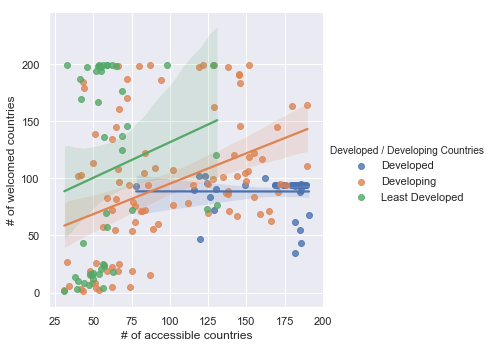

In [93]:
sns.set()

# Plot sepal with as a function of sepal_length across days
g = sns.lmplot(x="visafree", y="visafreeTO", hue="Developed / Developing Countries",
               truncate=True, height=5, data=df_pivot_flattened)

# Use more informative axis labels than are provided by default
g.set_axis_labels("# of accessible countries", "# of welcomed countries")

## Correlation between sub-region and visa free

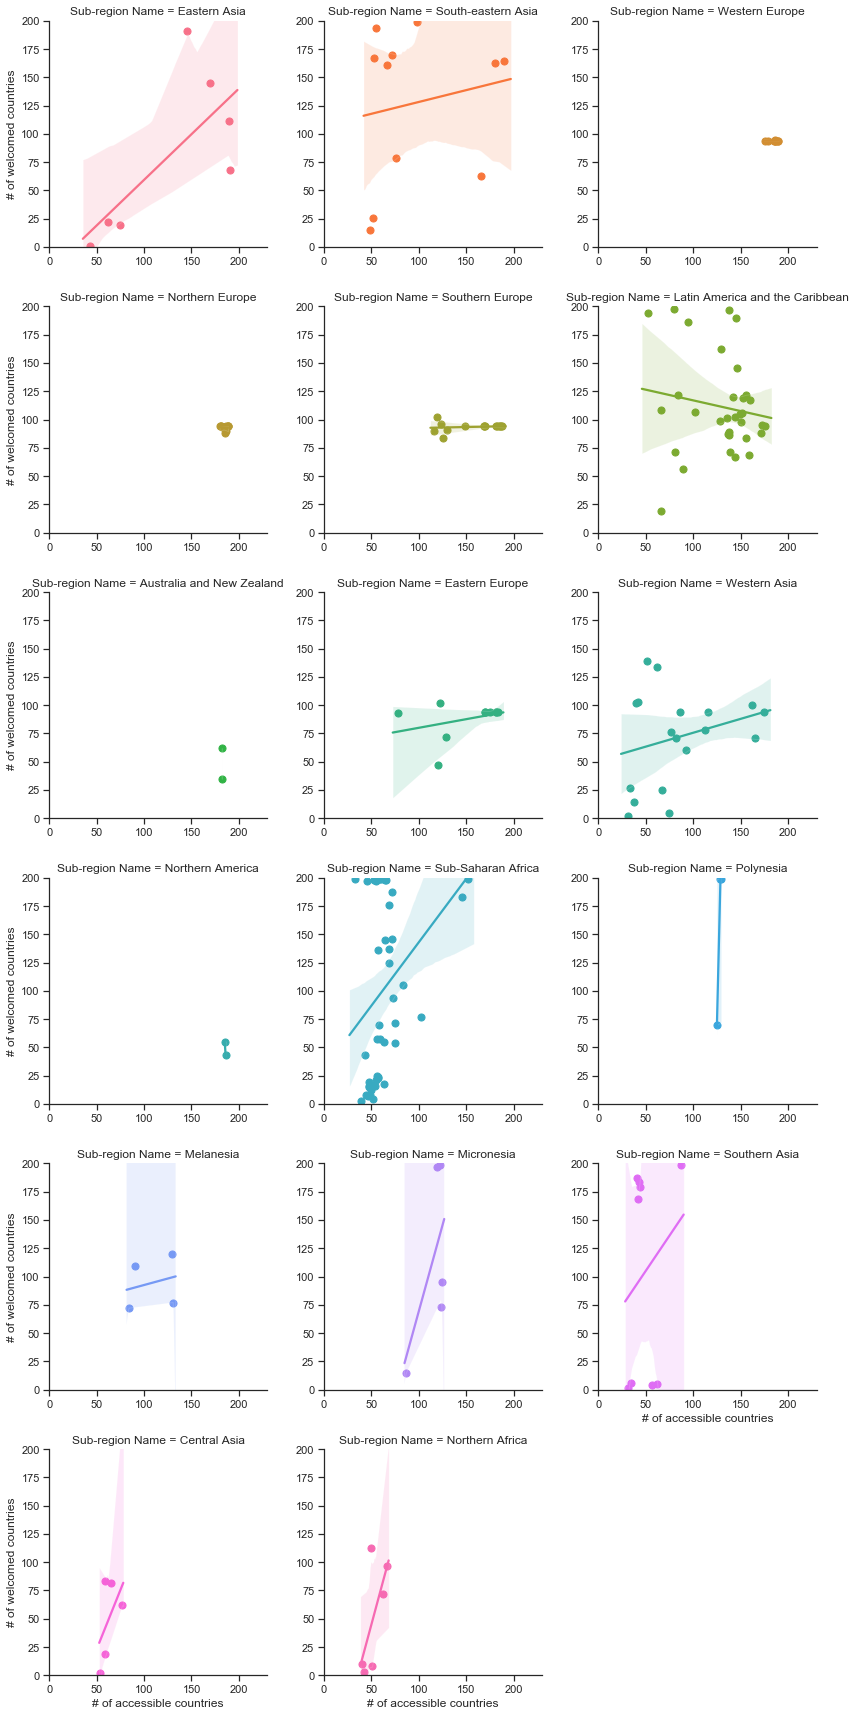

In [94]:
sns.set(style="ticks")

# Show the results of a linear regression within each dataset
g = sns.lmplot(x="visafree", y="visafreeTO", col="Sub-region Name", hue="Sub-region Name", data=df_pivot_flattened,
               sharex=False,sharey=False,
               col_wrap=3,
               #ci=None, 
               #palette="muted",
               height=4,
               scatter_kws={"s": 50, "alpha": 1}
              )

# control x and y limits
g.set(ylim=(0, 200))
g.set(xlim=(0, 230))

# Use more informative axis labels than are provided by default
g.set_axis_labels("# of accessible countries", "# of welcomed countries")

## Heatmap of the new passport ranking

In [321]:
data = [ dict(
        type = 'choropleth',
        locations = df_pivot_flattened['country_alpha_3code'],
        z = df_pivot_flattened['New_Overall_ranking'],
        text = "<br />" + df_pivot_flattened['passportfrom_Country_name'] + "'s passport gives you access to"
                + "<br />" + df_pivot_flattened['visafree'].astype(int).astype(str) + " destinations visa-free (over " + str(df_visa_free['countryto_alpha_2code'].nunique()) + " possible)"
                + "<br /><br />" + "It ranks " +  df_pivot_flattened['New_Overall_ranking'].astype(int).astype(str) + " th overall, " + df_pivot_flattened['New_Overall_ranking_bySubRegion'].astype(int).astype(str) + " th in " + df_pivot_flattened['Sub-region Name'] 
                + "<br /><br />That's a visa-free coverage of:"
                + "<br />" + (df_pivot_flattened['UN_World_GDP_percent'].astype(float)*100).astype(int).astype(str) + " % of the world's GDP"  
                + "<br />" + (df_pivot_flattened['UN_population_Value_2015_percent'].astype(float)*100).astype(int).astype(str) + " % of the world's population"
                + "<br />" + (df_pivot_flattened['Surface_area_convered_percent'].astype(float)*100).astype(int).astype(str) +  " % of the earth's land surface"
                + "<br />" + (df_pivot_flattened['unesco_total_sites_percent'].astype(float)*100).astype(int).astype(str) + " % of the Unesco's heritage sites"
                + "<br /><br />In " + df_pivot_flattened['passportfrom_Country_name'] + ", " + df_pivot_flattened['visafreeTO'].astype(int).astype(str) + " citizenships are welcomed visa-free"
                + "<br />" + "That's a ratio of " + df_pivot_flattened['visaFreeRatio'].astype(str),
        autocolorscale = True,
        reversescale = True,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            tickmode = 'array',
            tickvals = [180,100,20],
            ticktext = ['Weak','Medium','Strong'],
            autotick = False,
            #tickprefix = 'test',
            title = 'Passport rank. 1 = best'),
      ) ]

layout = dict(
    title = 'Passport rank heatmap',
    geo = dict(
        showframe = True,
        showcoastlines = True,
        projection = dict(
            type = 'Mercator'
        )
    )
)

fig = dict( data=data, layout=layout )
py.iplot( fig, validate=False, filename='passports-world-map1' )

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~jeremielamboley/0 or inside your plot.ly account where it is named 'passports-world-map'


C:\Users\Jrmy\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



## Heatmap visualization of the ratio countries accessibles vs countries welcomed visa-free

In [345]:
data = [ dict(
        type = 'choropleth',
        locations = df_pivot_flattened['country_alpha_3code'],
        z = df_pivot_flattened['visaFreeRatio'],
        text = "<br />" + df_pivot_flattened['passportfrom_Country_name'] + "'s passport gives you access to"
                + "<br />" + df_pivot_flattened['visafree'].astype(int).astype(str) + " destinations"
                + "<br /><br />" + df_pivot_flattened['visafreeTO'].astype(int).astype(str) + " citizenships are welcomed visa-free"
                + "<br /><br />" + "That's a ratio of " + round(df_pivot_flattened['visaFreeRatio'],1).astype(str),
        autocolorscale = False,
        reversescale = False,
        colorscale = [[0, 'rgb(51,160,44,0.5)'], #green
                      [0.05, 'rgb(178,223,138,0.5)'], #light green
                      [0.08, 'rgb(255,255,255,0.5)'], #white
                      [0.12, 'rgb(251,154,153,0.5)'], # salmon
                      [1, 'rgb(227,26,28,0.5)']], #red
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
    
        colorbar = dict(
            autotick = False,
            tickmode = 'array',
            #tickprefix = '',
            title = 'Ratio'),
      ) ]



layout = dict(
    title = 'ratio countries accessibles vs countries welcomed visa-free',
    geo = dict(
        showframe = True,
        showcoastlines = True,
        projection = dict(
            type = 'Mercator'
        )
    )
)

fig = dict( data=data, layout=layout )
py.iplot( fig, validate=False, filename='passports-world-map2' )

PlotlyRequestError: Hi there, you've reached the threshold of 100 combined image exports and chart saves per 24h period. If you need to raise your daily limit, please consider upgrading to a paid plan
(see: https://plot.ly/products/cloud ).